In [1]:
import os
import time
import sys
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Generate model that returns the prediction

Note that while training the model, I have only trained it on the dataset provided without applying any data augmentation techniques. Training accuracy obtained was ~63%

In [2]:
# helper method to define model
def deepnn(x):
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    
    # Conv Layer 1
    W_conv1 = tf.get_variable("weight_1", shape=[5, 5, 1, 6], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv1 = tf.get_variable("bias_1", shape=[6], initializer=tf.constant_initializer(0.1))
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # Max Pooling Layer 1
    h_pool1 = max_pool_2x2(h_conv1)

    # Conv Layer 2
    W_conv2 = tf.get_variable("weight_2", shape=[5, 5, 6, 16], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv2 = tf.get_variable("bias_2", shape=[16], initializer=tf.constant_initializer(0.1))
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # Max Pooling Layer 2
    h_pool2 = max_pool_2x2(h_conv2)

    h_pool_flatten = tf.reshape(h_pool2, (-1, 7*7*16))

    # Fully Connected 
    W_fc1 = tf.get_variable("weight_3", shape=[7*7*16, 120], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_fc1 = tf.get_variable("bias_3", shape=[120], initializer=tf.constant_initializer(0.1))
    h_fc1 = tf.matmul(h_pool_flatten, W_fc1) + b_fc1
    
    # Fully connected 2
    W_fc2 = tf.get_variable("weight_4", shape=[120, 10], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_fc2 = tf.get_variable("bias_4", shape=[10],initializer=tf.constant_initializer(0.1))
    y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2
    
    return y_conv

# Helper functions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape, i):
    return tf.get_variable("weight", shape=shape, initializer=tf.truncated_normal_initializer(stddev=0.1))


def bias_variable(shape, i):
    return tf.get_variable("bias", shape=shape, initializer=tf.constant_initializer(0.1))

In [3]:
# create Dummy class 
class Dummy():
    pass

env = Dummy()

In [4]:
def _prod(iterable):
    ret = 1
    for x in iterable:
        ret *= x
    return ret

In [5]:
# def _deepfoolx(model, x, epochs, eta, clip_min, clip_max):
    
#     y0 = tf.stop_gradient(model(x))
#     y0 = tf.reshape(y0, [-1])
#     k0 = tf.argmax(y0)
    
#     ydim = y0.get_shape().as_list()[0]
#     xdim = x.get_shape().as_list()[1:]
#     xflat = _prod(xdim)
    
#     def _cond(i, z):
#         xadv = tf.clip_by_value(x + z*(1+eta), clip_min, clip_max)
#         y = tf.reshape(model(xadv), [-1])
#         k = tf.argmax(y)
#         print("I'm evaluating the condition")
        
#         return tf.logical_and(tf.less(i, epochs), tf.equal(k0, k))
    
#     def _body(i, z):
#         xadv = tf.clip_by_value(x+z*(1+eta), clip_min, clip_max)
#         y = tf.reshape(model(xadv), [-1])
        
#         gs = [tf.reshape(tf.gradients(y[i], xadv)[0], [-1]) for i in range(ydim)]
#         g = tf.stack(gs, axis=0)
        
#         yk, yo = y[k0], tf.concat((y[:k0], y[k0+1:]), axis=0)
#         gk, go = g[k0], tf.concat((g[:k0], g[k0+1:]), axis=0)
    
#         yo.set_shape(ydim-1)
#         go.set_shape([ydim-1, xflat])
        
#         a = tf.abs(yo - yk)
#         b = go - gk
#         c = tf.norm(b, axis=1)
#         score = a / c
#         ind = tf.argmin(score)
        
#         si, bi = score[ind], b[ind]
#         dx = si * bi
#         dx = tf.reshape(dx, [-1]+xdim)
        
#         return i+1, z+dx
    
#     _, noise = tf.while_loop(_cond, _body, [0, tf.zeros_like(x)], name='_deepfoolx', back_prop=False)
    
#     return noise

def _deepfoolx(model, x, epochs, eta, clip_min, clip_max, min_prob):
    """DeepFool for multi-class classifiers.
    Assumes that the final label is the label with the maximum values.
    """
    y0 = tf.stop_gradient(model(x))
    y0 = tf.reshape(y0, [-1])
    k0 = tf.argmax(y0)

    ydim = y0.get_shape().as_list()[0]
    xdim = x.get_shape().as_list()[1:]
    xflat = _prod(xdim)

    def _cond(i, z):
        xadv = tf.clip_by_value(x + z*(1+eta), clip_min, clip_max)
        y = tf.reshape(model(xadv), [-1])
        p = tf.reduce_max(y)
        k = tf.argmax(y)
        return tf.equal(k0, k)

    def _body(i, z):
        xadv = tf.clip_by_value(x + z*(1+eta), clip_min, clip_max)
        y = tf.reshape(model(xadv), [-1])

        gs = [tf.reshape(tf.gradients(y[i], xadv)[0], [-1])
              for i in range(ydim)]
        g = tf.stack(gs, axis=0)

        yk, yo = y[k0], tf.concat((y[:k0], y[(k0+1):]), axis=0)
        gk, go = g[k0], tf.concat((g[:k0], g[(k0+1):]), axis=0)

        yo.set_shape(ydim - 1)
        go.set_shape([ydim - 1, xflat])

        a = tf.abs(yo - yk)
        b = go - gk
        c = tf.norm(b, axis=1)
        score = a / c
        ind = tf.argmin(score)

        si, bi = score[ind], b[ind]
        dx = si * bi
        dx = tf.reshape(dx, [-1] + xdim)
        dx = tf.Print(dx, [dx])
        return i+1, z+dx

    _, noise = tf.while_loop(_cond, _body, [0, tf.zeros_like(x)],
                             name='_deepfoolx', back_prop=False)
    return noise

In [6]:
def deepfool(model, x, noise=False, eta=0.01, epochs=3, clip_min=0.0, clip_max=1.0):
    
    y = tf.stop_gradient(model(x))
    
    fn = _deepfoolx
    
    def _f(xi):
        xi = tf.expand_dims(xi, axis=0)
        z = fn(model, xi, eta=eta, epochs=epochs, clip_min=clip_min, clip_max=clip_max, min_prob=0.0)
        return z[0]
    
    delta = tf.map_fn(_f, x, dtype=(tf.float32), back_prop=False, name='deepfool')
    
    if noise:
        return delta
    
    xadv = tf.stop_gradient(x + delta*(1 + eta))
    xadv = tf.clip_by_value(xadv, clip_min, clip_max)
    
    return xadv
    

In [7]:
# defining environment in which the model is set

with tf.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, 28, 28, 1),
                           name='x')
    env.y = tf.placeholder(tf.float32, (None, 10), name='y')
    env.ybar = deepnn(env.x)

    with tf.variable_scope('acc'):
        count = tf.equal(tf.argmax(env.y, axis=1), tf.argmax(env.ybar, axis=1))
        env.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')

    with tf.variable_scope('loss'):
        xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                       logits=env.ybar)
        env.loss = tf.reduce_mean(xent, name='loss')

    optimizer = tf.train.AdamOptimizer()
    env.train_op = optimizer.minimize(env.loss)

    env.saver = tf.train.Saver(tf.global_variables()[:8])

with tf.variable_scope('model', reuse=True):
    env.adv_epochs = tf.placeholder(tf.int32, (), name='adv_epochs')
    env.xadv = deepfool(deepnn, x=env.x, epochs=env.adv_epochs)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [8]:
sess = tf.InteractiveSession()

In [9]:
# Load trained model

env.saver.restore(sess, './mnist_model/model_chkpt-9990')

INFO:tensorflow:Restoring parameters from ./mnist_model/model_chkpt-9990


In [10]:
def make_deepfool(sess, env, X_data, epochs=1, batch_size=128):
    """
    Generate Deepfool by running env.xadv.
    """
    print('\nMaking adversarials via DeepFool')
    print('Number of epochs= ', epochs)

    X_adv = np.empty_like(X_data)

    adv = sess.run(env.xadv, feed_dict={
        env.x: X_data,
        env.adv_epochs: epochs})
    X_adv[0] = adv
    print('Done')

    return X_adv

In [11]:
def predict(sess, env, X_data, batch_size=128):
    """
    Do inference by running env.ybar.
    """
    print('\nPredicting')
    n_classes = env.ybar.get_shape().as_list()[1]

    y_batch = sess.run(env.ybar, feed_dict={env.x: X_data})
    yval = y_batch
    print()
    return yval

##### The following three cells are an alternate way to load the data 

In [12]:
# filename = './cifar/tfrecords/eval.tfrecords/'
# record_iterator = tf.python_io.tf_record_iterator(filename)
# serialized_img_example = next(record_iterator)

In [13]:
# serialized_img_example = next(record_iterator)

In [14]:
# example = tf.train.Example()
# example.ParseFromString(serialized_img_example)
# image = example.features.feature['image'].bytes_list.value
# label = example.features.feature['label'].int64_list.value[0]

### Loading data from pickle file directly

In [15]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [66]:
test_x = mnist.test.images.reshape(-1, 784)[2]
test_y = mnist.test.labels.reshape(-1, 10)[2]

new_img = test_x.reshape((28, 28, 1))

In [67]:
import matplotlib.pyplot as plt

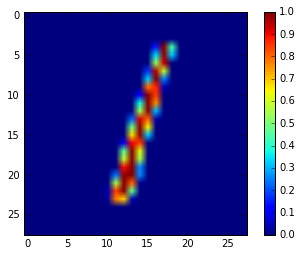

In [68]:
# plt.imshow(new_img.reshape((28, 28)))
# plt.savefig('./cifar_adv/cw/actual_1.png')

fig, ax = plt.subplots()

im = ax.imshow(new_img.reshape((28, 28)), cmap='jet')

fig.colorbar(im, ax=ax)

# plt.savefig('./mnist_adv/7/original.png')

In [69]:
test_y

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [70]:
# Adding an extra dimension

img = np.expand_dims(new_img, axis=0)

In [71]:
img.shape

(1, 28, 28, 1)

In [72]:
# Predicting output on original image

op = predict(sess, env, img)


Predicting
()


In [73]:
print(op)
np.argmax(op, axis=1)

[[-1.2842351  10.42824     1.4004627  -1.5610291   3.0630944  -2.1460145
   0.24728364  3.3212185   0.09893385 -1.5966411 ]]


array([1])

In [74]:
X_adv = make_deepfool(sess, env, img)


Making adversarials via DeepFool
('Number of epochs= ', 1)
Done


In [75]:

adv_op = predict(sess, env, X_adv)


Predicting
()


In [76]:
print(adv_op)
np.argmax(adv_op)

[[-4.306804   -3.736172    2.88959     1.483598   -4.2972636  -0.20738117
  -3.2876508   7.4226036   3.7706087  -2.7080252 ]]


7

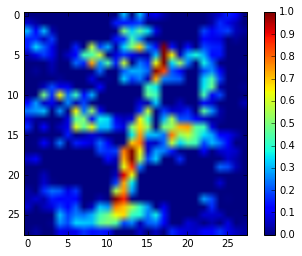

In [77]:
# plt.imshow(xadv.reshape(28, 28))
# plt.savefig('./cifar_adv/cw/actual_1_adv_3.png')

fig, ax = plt.subplots()

im = ax.imshow(X_adv.reshape((28, 28)), cmap='jet')

fig.colorbar(im, ax=ax)

plt.savefig('./mnist_adv/1/deepfool-7.png')

In [78]:
diff_img = X_adv - img

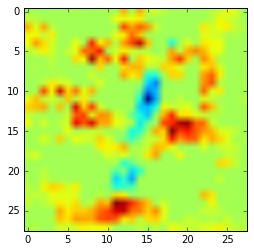

In [79]:
plt.imshow(diff_img.reshape(28, 28))
# plt.savefig('./cifar_adv/cw/diff_1_3.png')